17.492810457516338 2.639241146210922e-05


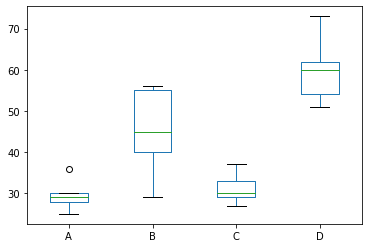

In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# load data file
d = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt", sep="\t")
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences 
# between different treatments
d.boxplot(column=['A', 'B', 'C', 'D'], grid=False)
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(d['A'], d['B'], d['C'], d['D'])
print(fvalue, pvalue)

In [2]:
# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(d.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
# replace column names
d_melt.columns = ['index', 'treatments', 'value']
d_melt

,index,treatments,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29
5,0,B,45
6,1,B,55
7,2,B,29
8,3,B,56
9,4,B,40


In [3]:
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(treatments),3010.95,3.0,17.49281,0.000026
Residual,918.00,16.0,NaN,NaN


In [4]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=d_melt, res_var='value', anova_model='value ~ C(treatments)')
res.anova_summary
# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),3.0,3010.95,1003.650,17.49281,0.000026
Residual,16.0,918.00,57.375,NaN,NaN


In [5]:
res = stat()
res.tukey_hsd(df=d_melt, res_var='value', xfac_var='treatments', anova_model='value ~ C(treatments)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,15.4,1.692871,29.107129,4.546156,0.025070
1,A,C,1.6,-12.107129,15.307129,0.472328,0.900000
2,A,D,30.4,16.692871,44.107129,8.974231,0.001000
3,B,C,13.8,0.092871,27.507129,4.073828,0.048178
4,B,D,15.0,1.292871,28.707129,4.428074,0.029578
5,C,D,28.8,15.092871,42.507129,8.501903,0.001000


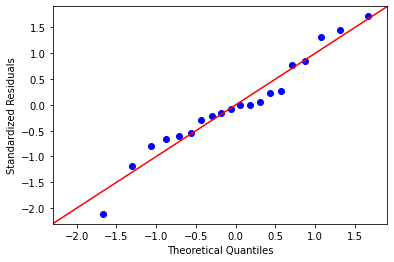

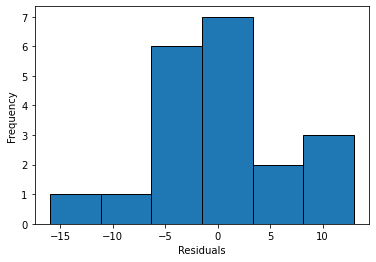

In [6]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [9]:
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9685019850730896 0.7229772806167603


As the p value is non significant, we fail to reject null hypothesis and conclude that data is drawn from normal distribution.
The data is drawn from normal distribution, use Bartlett’s test to check the Homogeneity of variances. Null hypothesis: samples from populations have equal variances.



In [10]:
w, pvalue = stats.bartlett(d['A'], d['B'], d['C'], d['D'])
print(w, pvalue)



5.687843565012841 0.1278253399753447


In [11]:
# if you have a stacked table, you can use bioinfokit v1.0.3 or later for the bartlett's test
from bioinfokit.analys import stat 
res = stat()
res.bartlett(df=d_melt, res_var='value', xfac_var='treatments')
res.bartlett_summary

,Parameter,Value
0,Test statistics (T),5.6878
1,Degrees of freedom (Df),3.0000
2,p value,0.1278


Levene’s test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution

In [12]:
res.levene(df=d_melt, res_var='value', xfac_var='treatments')
res.levene_summary

,Parameter,Value
0,Test statistics (W),1.9220
1,Degrees of freedom (Df),3.0000
2,p value,0.1667
